### Main Parts and Functions of the Notebook

This notebook demonstrates how to create a simple podcast generation workflow using LangChain, LangGraph, and the Tavily API.

Here's a breakdown of the key components:

1.  **Setting up APIs:**
    *   Retrieving API keys for Gemini and Tavily from Colab's user data secrets.
    *   Installing necessary libraries (`langchain_google_genai`, `langchain`, `tavily-python`, `langgraph`).
    *   Initializing the `ChatGoogleGenerativeAI` model for text generation.
    *   Initializing the `TavilyClient` for web search.

2.  **Defining the State:**
    *   The `PodcastState` TypedDict defines the structure of the data that will be passed between different steps in the workflow. It includes fields for the `topic`, `research_material`, `key_points`, and `script`.

3.  **Defining the Nodes (Functions):**
    *   `researcher_node`: This function takes the `topic` from the state, uses the Tavily API to perform a web search, and updates the state with the gathered `research_material`.
    *   `synthesizer_node`: This function takes the `research_material`, uses the language model (`llm`) to extract key points, and updates the state with a list of `key_points`.
    *   `writer_node`: This function takes the `topic` and `key_points`, uses the language model (`llm`) to generate a podcast monologue script, and updates the state with the final `script`.

4.  **Building the Graph:**
    *   `StateGraph`: This is the core component from LangGraph that allows us to define a directed graph representing the workflow.
    *   Adding Nodes: The `researcher_node`, `synthesizer_node`, and `writer_node` are added as nodes to the graph.
    *   Defining Edges: The `add_edge` method specifies the flow of execution between the nodes, starting from `START`, going through `researcher`, `synthesizer`, and `writer`, and ending at `END`.

5.  **Compiling and Running the Graph:**
    *   `graph.compile()`: This compiles the defined graph into an executable application.
    *   `app.invoke({'topic': 'Future of AI'})`: This runs the compiled graph with an initial state, in this case, setting the `topic` to 'Future of AI'. The graph then executes the nodes in the defined order, updating the state as it goes.

6.  **Output:**
    *   `final_state['script']`: Accessing the `script` key in the final state retrieves the generated podcast monologue.

In [ ]:
from google.colab import userdata

# Retrieve the secret key for the Gemini API from Colab's user data secrets.
gemini_api_key=userdata.get("GEMINI_API_KEY")

In [ ]:
# Install the langchain_google_genai library, which provides integration with Google's Generative AI models for LangChain.
!pip install langchain_google_genai

In [ ]:
# Install the langchain library, which is a framework for developing applications powered by language models.
!pip install langchain

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the ChatGoogleGenerativeAI model with a specific model name, temperature for creativity, and the retrieved API key.
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite', temperature=0.9, api_key=gemini_api_key)

In [ ]:
from typing import TypedDict, List

# Define a TypedDict class to represent the state of the podcast generation process.
# This helps structure the data passed between different nodes in the LangGraph.
class PodcastState(TypedDict):
  topic: str # The topic of the podcast.
  research_material: str # The raw research material gathered for the topic.
  key_points: List[str] # A list of key points extracted from the research material.
  script: str # The final podcast script generated.

In [ ]:
# Install the tavily-python library, a tool for searching and retrieving information.
!pip install tavily-python

In [ ]:
from tavily import TavilyClient
# Retrieve the secret key for the Tavily API from Colab's user data secrets.
tavily_api_key=userdata.get("TAVILY_KEY")

# Initialize the TavilyClient with the retrieved API key.
tavily_client = TavilyClient(api_key=tavily_api_key)
# Perform a search using the Tavily client for the query "Who is Leo Messi?".
response = tavily_client.search("Who is Leo Messi?")

# Print the search response. The output shows a dictionary containing search results,
# including URLs, titles, and content snippets, along with a confidence score for each result.
print(response)

{'query': 'Who is Leo Messi?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://en.wikipedia.org/wiki/Lionel_Messi', 'title': 'Lionel Messi', 'content': "An Argentine international,Messiis the national team's all-time leading goalscorer and most-capped player. Several years after his senior debut in 2005, he", 'score': 0.8080827, 'raw_content': None}, {'url': 'https://www.biography.com/athletes/lionel-messi', 'title': 'Lionel Messi: Biography, Soccer Player, Inter Miami CF ...', 'content': 'Lionel Messi, a forward for Inter Miami CF, is one of the world’s greatest soccer players and helped the Argentina national team win its third FIFA World Cup in 2022. Messi, now playing for Inter Miami CF of the MLS, helped his home country win soccer’s biggest event for the first time since 1986, scoring two goals in the final and leading Argentina to a 4-2 win over Kylian Mbappé and France on penalties. Lionel Messi is an Argentinian soccer player who has pla

In [ ]:
# Extract the content of the search results from the Tavily response and join them
# into a single string with "---" as a separator between each content snippet.
# The output is a single string containing the concatenated content from the search results.
"\n\n---\n\n".join([res["content"] for res in response['results']])

"An Argentine international,Messiis the national team's all-time leading goalscorer and most-capped player. Several years after his senior debut in 2005, he\n\n---\n\nLionel Messi, a forward for Inter Miami CF, is one of the world’s greatest soccer players and helped the Argentina national team win its third FIFA World Cup in 2022. Messi, now playing for Inter Miami CF of the MLS, helped his home country win soccer’s biggest event for the first time since 1986, scoring two goals in the final and leading Argentina to a 4-2 win over Kylian Mbappé and France on penalties. Lionel Messi is an Argentinian soccer player who has played for FC Barcelona, Paris Saint-Germain, and currently, the MLS club Inter Miami CF as well as the Argentina national team.\n\n---\n\n# Lionel Messi Lionel Messi is a football player from Argentina who plays for Inter Miami. He has won the Ballon D'Or, the annual award given to the best player in the world, 8 times, 2022 FIFA World Cup winner and an Olympic gold m

In [ ]:
def researcher_node(state: PodcastState)-> dict:
  """
    Researches a topic using Tavily and aggregates the content.

    Args:
        state (PodcastState): The current state of the graph.
          - state['topic']: The topic to research.

    Returns:
        dict: A dictionary with the updated 'research_material'.
          - 'research_material': A string containing the concatenated content from the search results.
    """
  # Use the Tavily client to search for information based on the topic from the state.
  results = tavily_client.search(state['topic'])
  # Extract the content from the search results and join them into a single string as we did in previous cell.
  research_data="\n\n---\n\n".join([res["content"] for res in results['results']])

  # Return the updated state with the research material added.
  return {"research_material": research_data}

In [ ]:
# Import necessary classes for creating chat prompts and parsing string outputs from language models.
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers.string import StrOutputParser

In [ ]:
def synthesizer_node(state: PodcastState):
  """
  Invokes LLM to give list of key points based on research_material.

  Args:
        state (PodcastState): The current state of the graph.
          - state['research_material']: The research material to synthesize.

  Returns:
        list of strings
          - 'key_points': A list of strings representing the extracted key points.
  """
  # Define a prompt template for the language model to extract key points from the research material.
  template = """Based on the following research, extract the 5 most important key points.

    RESEARCH MATERIAL:
    {research_material}

    INSTRUCTIONS:
    Present the key points as a list, with each point on a new line. Do NOT number them or use bullet points.
    """
  # Create a ChatPromptTemplate from the template string.
  prompt = ChatPromptTemplate.from_template(template)
  # Create a LangChain chain: prompt -> language model -> string output parser -> split the output by newline.
  chain = prompt | llm | StrOutputParser() | (lambda text: text.strip().split('\n'))
  # Invoke the chain with the research material from the state.
  response=chain.invoke({"research_material": state['research_material']})
  # Return the updated state with the extracted key points.
  return {"key_points": response}

In [ ]:
def writer_node(state: PodcastState):
  """
  Invokes LLM to create monologue

  Args:
        state (PodcastState): The current state of the graph.
          - state['topic']: The topic of the podcast.
          - state['key_points']: The key points to include in the monologue.

  Returns:
        a monologue (str)
          - 'script': A string containing the generated podcast monologue.
  """
  # Format the key points into a string for inclusion in the prompt.
  formatted_string = "\n- ".join(state['key_points'])
  # Define a prompt template for the language model to write a podcast monologue.
  template = """You are a podcast host. Write an engaging 200-word monologue about '{topic}' based on these key points: {key_points}.
              Make it conversational, insightful, and easy for a general audience to understand.
              """
  # Create a ChatPromptTemplate from the template string.
  prompt = ChatPromptTemplate.from_template(template)
  # Create a LangChain chain: prompt -> language model -> string output parser.
  chain = prompt | llm | StrOutputParser()
  # Invoke the chain with the topic and formatted key points from the state.
  response = chain.invoke(
      {
          'topic': state['topic'],
          'key_points': formatted_string
          }
      )
  # Return the updated state with the generated script.
  return {'script': response}

In [ ]:
# Install the langgraph library, which is used for building stateful, multi-actor applications with language models.
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.3 MB/s eta 0:00:00


In [ ]:
from langgraph.graph import StateGraph, END, START
# Import necessary classes for building a state graph in LangGraph.

# Initialize a StateGraph with the defined PodcastState. This graph will manage
# the state transitions during the podcast generation process.
graph=StateGraph(PodcastState)

In [ ]:
# Add nodes to the state graph, associating each node name ('researcher', 'synthesizer', 'writer')
# with its corresponding function.
graph.add_node('researcher', researcher_node)
graph.add_node('synthesizer', synthesizer_node)
graph.add_node('writer', writer_node)

# Define the edges of the graph, specifying the flow of execution between nodes.
# The process starts at 'researcher', then goes to 'synthesizer', then to 'writer', and finally ends.
graph.add_edge(START, 'researcher')
graph.add_edge('researcher', 'synthesizer')
graph.add_edge('synthesizer', 'writer')

# Define the end point of the graph.
graph.add_edge('writer', END)

# The output shows the StateGraph object, representing the structure of the defined graph.

In [ ]:
# Compile the state graph into an executable application. This prepares the graph
# for invocation.
app=graph.compile()

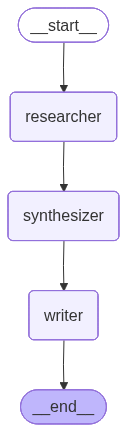

In [ ]:
# Display the compiled state graph application.
# The output shows a CompiledStateGraph object, indicating that the graph has been compiled successfully.
app

In [ ]:
# Invoke the compiled graph with an initial state containing the topic 'Future of AI'.
# This starts the execution of the graph, running through the defined nodes and edges.
final_state=app.invoke({'topic': 'Future of AI'})

In [ ]:
# Access the 'script' key from the final state of the graph.
# The output is the generated podcast monologue script based on the research and synthesis performed by the graph.
final_state['script']

'**(Intro Music fades)**\n\n**Host:** Hey everyone, and welcome back to "Future Forward"! Today, we\'re diving headfirst into a topic that\'s buzzing everywhere: the Future of AI. Now, forget the sci-fi robots for a second. In reality, AI is already quietly boosting our productivity and fueling economic growth. Think smarter tools helping us make better decisions, faster.\n\nThis isn\'t just for tech geeks either! AI is set to shake up everything from how doctors diagnose illnesses to how factories churn out goods, and even how we interact with customer service. That means smoother experiences for all of us.\n\nThe future of AI development is fascinating. We\'re seeing massive, open-source models that anyone can play with, alongside incredibly efficient, smaller ones designed for specific tasks. It\'s a two-pronged approach!\n\nBut it’s not all sunshine and rainbows. We need to be real about the challenges: job displacement, those unsettling deepfakes, and the ever-present cyber threat